<a href="https://colab.research.google.com/github/Apaulgithub/Transformer_variants_for_text_classification/blob/main/Comparative_Study_of_Transformer_Variants_for_Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import time
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IMDb dataset and create small sample for fast runs
dataset = load_dataset("imdb")
small_train = dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))

# Model list with parameter counts (approximate)
model_infos = {
    "distilbert-base-uncased": {"parameters": 66},
    "albert-base-v2": {"parameters": 12}
}

Using device: cuda


In [ ]:
def preprocess(tokenizer, texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [ ]:
results = {}

for model_name, info in model_infos.items():
    print(f"\nProcessing {model_name} ...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_ds = small_train.map(lambda x: preprocess(tokenizer, x['text']), batched=True)
    test_ds = small_test.map(lambda x: preprocess(tokenizer, x['text']), batched=True)

    # Rename label to labels for Trainer API
    train_ds = train_ds.rename_column("label", "labels")
    test_ds = test_ds.rename_column("label", "labels")

    # Set format for pytorch tensors
    train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    test_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Load pretrained model and move to GPU if available
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        save_strategy="no",
        logging_dir='./logs',
        disable_tqdm=True,
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
    )

    # Fine-tune the model
    trainer.train()

    # Measure inference time for evaluation
    start_time = time.time()
    eval_results = trainer.evaluate()
    inference_time = time.time() - start_time

    results[model_name] = {
        "accuracy": eval_results['eval_accuracy'],
        "precision": eval_results['eval_precision'],
        "recall": eval_results['eval_recall'],
        "f1": eval_results['eval_f1'],
        "parameters_M": info["parameters"],
        "inference_time_s": inference_time
    }
    print(f"{model_name} evaluation results: {eval_results}")
    print(f"Inference time: {inference_time:.4f} seconds")


Processing distilbert-base-uncased ...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.3513, 'grad_norm': 24.210487365722656, 'learning_rate': 1.0000000000000001e-07, 'epoch': 2.0}
{'train_runtime': 52.5731, 'train_samples_per_second': 76.085, 'train_steps_per_second': 9.511, 'train_loss': 0.3513427429199219, 'epoch': 2.0}
{'eval_loss': 0.5814940333366394, 'eval_accuracy': 0.826, 'eval_precision': 0.799618320610687, 'eval_recall': 0.8586065573770492, 'eval_f1': 0.8280632411067194, 'eval_runtime': 3.7574, 'eval_samples_per_second': 266.139, 'eval_steps_per_second': 33.267, 'epoch': 2.0}
distilbert-base-uncased evaluation results: {'eval_loss': 0.5814940333366394, 'eval_accuracy': 0.826, 'eval_precision': 0.799618320610687, 'eval_recall': 0.8586065573770492, 'eval_f1': 0.8280632411067194, 'eval_runtime': 3.7574, 'eval_samples_per_second': 266.139, 'eval_steps_per_second': 33.267, 'epoch': 2.0}
Inference time: 3.7666 seconds

Processing albert-base-v2 ...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7113, 'grad_norm': 8.961522102355957, 'learning_rate': 1.0000000000000001e-07, 'epoch': 2.0}
{'train_runtime': 97.0223, 'train_samples_per_second': 41.228, 'train_steps_per_second': 5.153, 'train_loss': 0.7112703857421875, 'epoch': 2.0}
{'eval_loss': 0.6943545341491699, 'eval_accuracy': 0.488, 'eval_precision': 0.488, 'eval_recall': 1.0, 'eval_f1': 0.6559139784946236, 'eval_runtime': 8.0594, 'eval_samples_per_second': 124.078, 'eval_steps_per_second': 15.51, 'epoch': 2.0}
albert-base-v2 evaluation results: {'eval_loss': 0.6943545341491699, 'eval_accuracy': 0.488, 'eval_precision': 0.488, 'eval_recall': 1.0, 'eval_f1': 0.6559139784946236, 'eval_runtime': 8.0594, 'eval_samples_per_second': 124.078, 'eval_steps_per_second': 15.51, 'epoch': 2.0}
Inference time: 8.0666 seconds


In [ ]:
# Create results DataFrame for tabular overview and plotting
df_results = pd.DataFrame(results).T
print("\nComparison Results:\n", df_results[['accuracy', 'parameters_M', 'inference_time_s']])


Comparison Results:
                          accuracy  parameters_M  inference_time_s
distilbert-base-uncased     0.826          66.0          3.766649
albert-base-v2              0.488          12.0          8.066614


/tmp/ipython-input-3160806560.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_results['parameters_M'][i]+0.5, df_results['accuracy'][i], model_name)


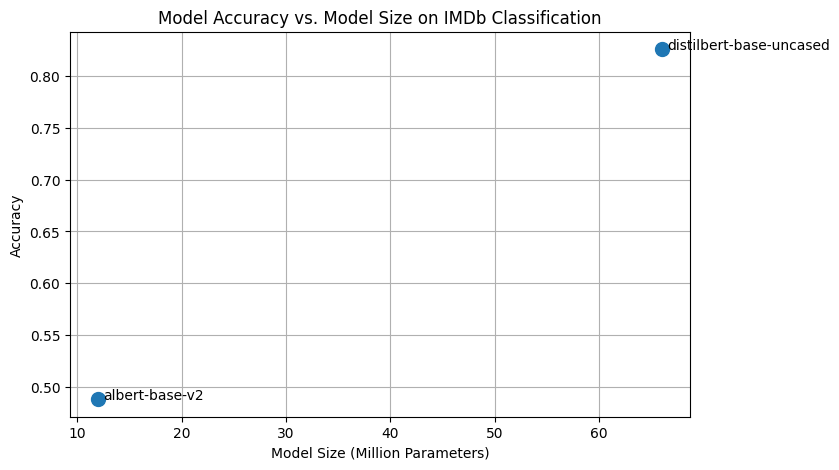

In [ ]:
# Plot Accuracy vs Model Size
plt.figure(figsize=(8,5))
plt.scatter(df_results['parameters_M'], df_results['accuracy'], s=100)
for i, model_name in enumerate(df_results.index):
    plt.text(df_results['parameters_M'][i]+0.5, df_results['accuracy'][i], model_name)

plt.xlabel('Model Size (Million Parameters)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Model Size on IMDb Classification')
plt.grid(True)
plt.show()